In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import read_table

Here we want to store player data to measure their similarity. To measure 2 player's similarity, we can be using multiple data points in multiple ways. Should we use only the last year's statistics, an average of the last couple, an average of all history, a list of the last couple, the list of history? PECOTA uses a three-year window... is that enough? If we use a list of a player's history, how do we deal with weights? Is there already research on this? How can we properly embbed player statistics in a vector... embeddings as a RNN output?

- For now assumptions are all weights are equal and a 3 year window is taken. Constant statistics are not repeated but yearly statistics are given a new column each

In [231]:
df = read_table("PlayerBatting", random_subset = 1)


In [232]:
def remove_last_year_for_each_player(df, players):
    df = df.drop(len(players) - 1)
    for i in range(len(players) - 1):
        if players[i] != players[i+1]:
            df = df.drop(i)
    
    return df.reset_index()

In [233]:
df_bat = df.copy()

df_bat["PA"] = df_bat["AB"] + df_bat["BB"] + df_bat["IBB"] + df_bat["HBP"]
df_bat["1B"] = df_bat["H"] - df_bat["2B"] - df_bat["3B"] - df_bat["HR"]

OnBaseP = (df_bat["BB"] + df_bat["IBB"] + df_bat["HBP"] + df_bat["H"]) / df_bat["PA"]
Slugging = (df_bat["1B"] + 2*df_bat["2B"] + 3*df_bat["3B"] + 4*df_bat["HR"]) / df_bat["AB"]
df_bat["OPS"] = OnBaseP + Slugging
df_bat["OPS"] = df_bat["OPS"].fillna(0)

df_bat["NextYearOPS"] = df_bat["OPS"].shift(-1)


players = df_bat["playerID"]
df = remove_last_year_for_each_player(df_bat, players)
y = df["NextYearOPS"]
df = df.drop(columns=["NextYearOPS"])

In [234]:
players = df["playerID"]

df = df.drop(columns=["Unnamed: 0", "playerID", "yearID", "stint", "teamID", "lgID", "G", "debut", "years_of_experience"])

constant_stats_columns = ['birthYear', 'weight', 'height', 'current_age']
yearly_stats_columns = ["AB", "R", "H", "2B", "3B", "HR", "RBI", "SB", "CS", "BB", "SO", "IBB", "HBP", "SH", "SF", "GIDP", "OPS"]
n_yearly_stats_columns = len(yearly_stats_columns)

columns = constant_stats_columns + list(map(lambda x: x + "1", yearly_stats_columns)) + list(map(lambda x: x + "2", yearly_stats_columns)) + list(map(lambda x: x + "3", yearly_stats_columns))

In [235]:
constant_stats_df = df[constant_stats_columns]
yearly_stats_df = df[yearly_stats_columns]
window_3_years = pd.DataFrame(columns=columns)

In [236]:
last_cutoff = 0
sequences = []
labels = []
input_size = len(df.columns)
window_size = 3


years_before = 0
for i in range(0, len(players)):
    constant_info = constant_stats_df.loc[i,:].tolist()
    
    if i > 0 and players[i] != players[i-1]:
        years_before = 0
    
    how_many_years_to_skip = max((window_size - years_before) - 1, 0)
    how_many_years_back_to_go = min(window_size - 1, years_before)
    
    for j in range(0, how_many_years_to_skip):
        constant_info += ([0] * n_yearly_stats_columns)
    
    for j in range(0, how_many_years_back_to_go + 1):
        constant_info += yearly_stats_df.loc[i-j, :].tolist()
        
    window_3_years.loc[i] = constant_info
    years_before += 1

In [237]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [238]:
X = window_3_years
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [239]:
knn = KNeighborsRegressor(n_neighbors=15)
knn.fit(X_train, y_train)

distances, indices = knn.kneighbors(X_test, n_neighbors=15)
print(indices)


[[3017 4000 1247 ... 8325 2995 3323]
 [2286  834 1692 ... 7903 4932 7870]
 [7896 2086 1058 ... 2631 5436 8033]
 ...
 [8614 4534 2681 ... 4313 7569 8012]
 [ 417 1515 2622 ... 2681 7570 8491]
 [5528 3726  116 ... 7611 2295 7078]]


In [245]:
def get_player(index):
    return players[index]

show_n = 10
_, indices = knn.kneighbors(X_test.iloc[:show_n, :], n_neighbors=15)

for i in range(show_n):
    player_to_compare = get_player(X_test.iloc[i, :].name)
    print("Players similar to: ", player_to_compare)
    s = ""
    for player_id in indices[i]:
        s += (get_player(player_id) + " / ")
    print(s)


Players similar to:  parenma01
difelmi01 / garcika01 / bordepa01 / bautijo02 / garcica01 / bordepa01 / munsoer01 / cummimi01 / difelmi01 / mirabdo01 / bennega01 / berryse01 / nievewi01 / diazma02 / elsteke01 / 
Players similar to:  parenma01
clarkje01 / benjami01 / byrneer01 / parenma01 / bennega01 / castial01 / molinjo01 / bordepa01 / ibanera01 / duceyro01 / diazma02 / ojedaau01 / moellch01 / hammoje01 / mirabdo01 / 
Players similar to:  parenma01
moellch01 / castrra01 / blanche01 / brosisc01 / mirabdo01 / bakopa01 / castial01 / ibanera01 / hornsa01 / molinjo01 / huntebr01 / espyce01 / cummimi01 / houstty01 / mordemi01 / 
Players similar to:  parenma01
mirabdo01 / huntebr01 / osikke01 / johnsbr01 / olivejo01 / jonesch05 / melvibo01 / betemwi01 / cairomi01 / baineha01 / ledeeri01 / coomero01 / hammoje01 / craigal01 / fabrejo01 / 
Players similar to:  parenma01
diazma02 / huntebr01 / blanche01 / gedmari01 / francbe01 / gomezch02 / mirabdo01 / colbrgr01 / fasansa01 / lopezlu02 / incavpe0

In [ ]:


data = []
for i in range(1,15):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'mse on {i} nearest-neighboors: {mse}%')
    data.append(mse)
    

mse on 1 nearest-neighboors: 0.044724204724252786%
mse on 2 nearest-neighboors: 0.030677569244628833%
mse on 3 nearest-neighboors: 0.02668760497664546%
mse on 4 nearest-neighboors: 0.024947227103325934%
mse on 5 nearest-neighboors: 0.023500876064301585%
mse on 6 nearest-neighboors: 0.02264798690186164%
mse on 7 nearest-neighboors: 0.022112690876337025%
mse on 8 nearest-neighboors: 0.021945793419449452%
mse on 9 nearest-neighboors: 0.021711436172593104%
mse on 10 nearest-neighboors: 0.021478476183555355%
mse on 11 nearest-neighboors: 0.021342939009205194%
mse on 12 nearest-neighboors: 0.02117706737052583%
mse on 13 nearest-neighboors: 0.021147874197007664%
mse on 14 nearest-neighboors: 0.02117067034332813%


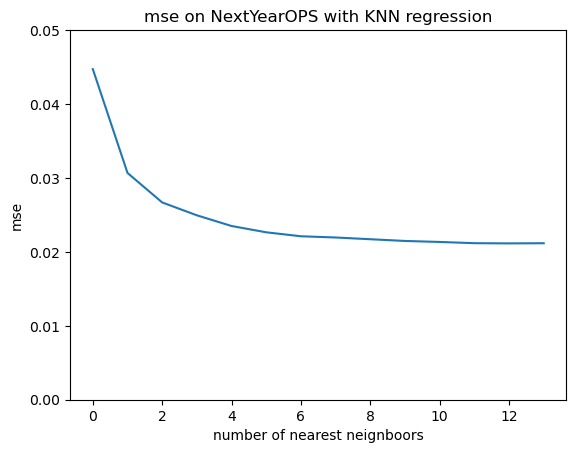

In [ ]:
    
plt.plot(data)
plt.xlabel("number of nearest neignboors")
plt.ylabel("mse")
plt.title(f"mse on {predicted_data} with KNN regression")
plt.ylim(0,0.05)
plt.show()